In [1]:
import sys
from SPARQLWrapper import SPARQLWrapper, JSON
import pandas as pd
import numpy as np

endpoint_url = "https://query.wikidata.org/sparql"
item = "item"


class Relation:
    """
    The class returned when createRelation is called.
    It contains string field with query.
    We call Relation.query when we need to do the query.
    """

    def __init__(self, entity_id: str, property_id: str, isSubject: bool, limit: int, rowVerbose: bool,
                 colVerbose: bool, time_property: str, time: str, name: str, label):
        self.entity_id = entity_id
        self.query_str = ""
        self.dic = {}
        self.result_dic = {"Entity ID": []}
        self.df = pd.DataFrame()
        self.count = 0
        self.time_property = time_property
        self.time = time
        self.limit = limit
        self.focus = "Entity ID"
        if property_id:
            self.extend(property_id, isSubject, name, rowVerbose, colVerbose, limit, time_property, time, label)

    def generate_html(self, name: str):
        html = (self.df).to_html()
        text_file = open(name, "w", encoding='utf-8')
        text_file.write(html)
        text_file.close()

    def query(self, require=None):
        if self.query_str == "":
            self.result_dic = {"Entity ID": ['http://www.wikidata.org/entity/' + str(self.entity_id)]}
            return self.result_dic
        results = get_results(endpoint_url, self.query_str)
        result_dict = {"Entity ID": ['http://www.wikidata.org/entity/' + str(self.entity_id)]}
        for i in range(1, self.count + 1):
            result_dict[self.dic[i]["name"] + '_' + self.dic[i]['property_id']] = []
            if self.dic[i]["colVerbose"]:
                result_dict[self.dic[i]["name"] + '_rank_' + self.dic[i]['property_id'] + '_rank'] = []
                for key, value in self.dic[i]["property_name_dic"].items():
                    result_dict[
                        self.dic[i]["name"] + "_" + value + '_' + self.dic[i]['property_id'] + '_' + str(key)] = []
                for key, value in self.dic[i]["ref_dic"].items():
                    result_dict[self.dic[i]["name"] + "_ref_" + self.dic[i]['property_id'] + '_' + str(key)] = []

            if self.dic[i]["label"]:
                result_dict[self.dic[i]["name"] + '_' + self.dic[i]['property_id'] + 'Label'] = []

        for result in results['results']['bindings']:
            for key, value in result_dict.items():
                if key in result.keys():
                    result_dict[key].append(result[key]['value'])
                else:
                    result_dict[key].append('NA')
        result_dict["Entity ID"] = ['http://www.wikidata.org/entity/' + str(self.entity_id)] * len(
            result_dict[self.dic[self.count]["name"] + '_' + self.dic[self.count]["property_id"]])
        self.result_dic = result_dict
        self.df = pd.DataFrame.from_dict(self.result_dic)
        for i in range(1, self.count + 1):
            if self.dic[i]["colVerbose"] and not self.dic[i]["rowVerbose"]:
                col = self.dic[i]['name'] + '_rank_' + self.dic[i]['property_id'] + '_rank'
                if any(self.df[col] == 'http://wikiba.se/ontology#PreferredRank'):
                    self.df = self.df.loc[self.df[col] == 'http://wikiba.se/ontology#PreferredRank']
                else:
                    self.df = self.df.loc[self.df[col] == 'http://wikiba.se/ontology#NormalRank']
        if require is not None:
            for r in require:
                self.df = self.df.loc[self.df[r] != 'NA']
        self.df = pd.DataFrame(data=self.df)
        return self.df
        # self.df = self.df.drop_duplicates()
        # self.df.to_csv(self.entity_id + '.csv')
        # return self.result_dic

    def extend(self, property_id: str, isSubject: bool, name: str, rowVerbose=False, colVerbose=False, limit=None,
               time_property=None, time=None, search=None, label=False):
        self.count += 1
        self.dic[self.count] = {}
        self.dic[self.count]["name"] = name
        self.dic[self.count]["focus"] = self.focus
        self.dic[self.count]["property_id"] = property_id
        self.dic[self.count]["isSubject"] = isSubject
        self.dic[self.count]["limit"] = limit
        self.dic[self.count]["rowVerbose"] = rowVerbose
        self.dic[self.count]["colVerbose"] = colVerbose
        self.dic[self.count]['time_property'] = time_property
        self.dic[self.count]['time'] = time
        self.dic[self.count]['search'] = search
        self.dic[self.count]['label'] = label
        if rowVerbose or colVerbose:
            self.dic[self.count]["property_name_dic"], self.dic[self.count][
                "ref_dic"] = self.search_property_for_verbose()
        if time_property and time:
            self.time_property = time_property
            self.time = time
        if limit:
            self.limit = limit
        self.query_str = self.define_query_relation()

    def changeFocus(self, name="Entity ID"):
        self.focus = name

    def define_query_relation(self):
        rdf_triple, time_filter, limit_statement = """""", """""", """"""
        if self.count < 1:
            return None
        focusChanges = 0
        for i in range(1, self.count + 1):
            if self.dic[i]["rowVerbose"] or self.dic[i]["colVerbose"]:
                if self.dic[i]["focus"] == "Entity ID":
                    if self.dic[i]["search"] is None:
                        rdf_triple += """OPTIONAL {"""
                    rdf_triple += """wd:""" + self.entity_id + """ p:""" + self.dic[i][
                        'property_id'] + """ ?statement_""" + str(i) + """. """ \
                                  + """?statement_""" + str(i) + """ ps:""" + self.dic[i][
                                      'property_id'] + """ ?""" + \
                                  self.dic[i]['name'] \
                                  + """_""" + self.dic[i]['property_id'] + """. """
                else:
                    if self.dic[i]["search"] is None:
                        rdf_triple += """OPTIONAL {"""
                    rdf_triple += """?""" + self.dic[i]["focus"] + """ p:""" + self.dic[i][
                        'property_id'] + """ ?statement_""" + str(i) + """. """ \
                                  + """?statement_""" + str(i) + """ ps:""" + self.dic[i][
                                      'property_id'] + """ ?""" + \
                                  self.dic[i]['name'] \
                                  + """_""" + self.dic[i]['property_id'] + """. """
                for key, value in self.dic[i]["property_name_dic"].items():
                    rdf_triple += """OPTIONAL { """ + """?statement_""" + str(i) + """ pq:""" + str(key) \
                                  + """ ?""" + self.dic[i]['name'] + """_""" + value + """_""" + self.dic[i][
                                      'property_id'] + """_""" + str(key) + """.} """
                for key, value in self.dic[i]["ref_dic"].items():
                    rdf_triple += """OPTIONAL { ?statement_""" + str(
                        i) + """ prov:wasDerivedFrom ?refnode_""" + str(
                        i) + """. ?refnode_""" + str(i) \
                                  + """ pr:""" + str(key) + """ ?""" + self.dic[i]['name'] + """_ref_""" + \
                                  self.dic[i][
                                      'property_id'] + """_""" + str(key) + """.} """
                rdf_triple += """OPTIONAL { ?statement_""" + str(i) + """ wikibase:rank ?""" + self.dic[i][
                    'name'] + """_rank_""" + self.dic[i]['property_id'] + """_rank. } """
            # none-verbose version
            else:
                if self.dic[i]["focus"] == "Entity ID":
                    if self.dic[i]["isSubject"]:
                        if self.dic[i]["search"] is None:
                            rdf_triple += """OPTIONAL {"""
                        rdf_triple += """?""" + self.dic[i]["name"] + """_""" + self.dic[i][
                            'property_id'] + """ wdt:""" + self.dic[i][
                                          "property_id"] + """ wd:""" + self.entity_id + """. """
                    else:
                        if self.dic[i]["search"] is None:
                            rdf_triple += """OPTIONAL {"""
                        rdf_triple += """wd:""" + self.entity_id + """ wdt:""" + self.dic[i][
                            "property_id"] + """ ?""" + \
                                      self.dic[i]["name"] + """_""" + self.dic[i]['property_id'] + """. """
                else:
                    if self.dic[i]["isSubject"]:
                        if self.dic[i]["search"] is None:
                            rdf_triple += """OPTIONAL {"""
                        rdf_triple += """?""" + self.dic[i]["name"] + """_""" + self.dic[i][
                            'property_id'] + """ wdt:""" + self.dic[i]["property_id"] + """ ?""" + self.dic[i][
                                          'focus'] + """. """
                    else:
                        if self.dic[i]["search"] is None:
                            rdf_triple += """OPTIONAL {"""
                        rdf_triple += """?""" + self.dic[i]['focus'] + """ wdt:""" + self.dic[i][
                            "property_id"] + """ ?""" + self.dic[i]["name"] + """_""" + self.dic[i][
                                          'property_id'] + """. """
            if i < self.count and self.dic[i]["focus"] != self.dic[i + 1]["focus"] and self.dic[i]["search"] is None:
                focusChanges += 1
            elif self.dic[i]["search"] is None:
                rdf_triple += """} """
        for i in range(focusChanges):
            rdf_triple += """} """
        for i in range(1, self.count + 1):
            if self.dic[i]['search'] is not None and self.dic[i]["search"] != '!NA':
                if isinstance(self.dic[i]['search'], tuple):
                    if isinstance(self.dic[i]['search'][0], str):
                        rdf_triple += """FILTER (YEAR(?""" + self.dic[i]['name'] + """_""" + self.dic[i][
                            'property_id'] + """) >= """ + \
                                      self.dic[i]['search'][0] + """ && YEAR(?""" + self.dic[i]['name'] + \
                                      """_""" + self.dic[i]['property_id'] + """) <= """ + self.dic[i]['search'][
                                          1] + """) """
                    else:
                        rdf_triple += """FILTER (?""" + self.dic[i]['name'] + """_""" + self.dic[i]['property_id'] + \
                                      """ >= """ + str(self.dic[i]['search'][0]) + """ && ?""" + self.dic[i]['name'] + \
                                      """_""" + self.dic[i]['property_id'] + """ <= """ + str(
                            self.dic[i]['search'][1]) + """) """
                else:
                    rdf_triple += """FILTER (?""" + self.dic[i]['name'] + """_""" + self.dic[i][
                        'property_id'] + """ = """ + \
                                  """wd:""" + self.dic[i]['search'] + """) """
        if self.time_property is not None:
            time_filter = """?""" + self.dic[1]["name"] + """ p:""" + self.time_property + """ ?pubdateStatement.	
                          ?pubdateStatement ps:""" + self.time_property + """ ?date	
                          FILTER (YEAR(?date) = """ + self.time + """)"""
        if self.limit is not None:
            limit_statement = """LIMIT """ + str(self.limit)
        label_statement = """Service wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en" }"""
        query = """SELECT DISTINCT"""
        for i in range(1, self.count + 1):
            if self.dic[i]["rowVerbose"] or self.dic[i]["colVerbose"]:
                query += """ ?""" + self.dic[i]["name"] + """_""" + self.dic[i]['property_id']
                if self.dic[i]["label"]:
                    query += """ ?""" + self.dic[i]["name"] + """_""" + self.dic[i]['property_id'] + """Label"""
                for key, value in self.dic[i]["property_name_dic"].items():
                    query += """ ?""" + self.dic[i]["name"] + """_""" + value + """_""" + self.dic[i][
                        'property_id'] + """_""" + str(key)
                for key, value in self.dic[i]["ref_dic"].items():
                    query += """ ?""" + self.dic[i]["name"] + """_ref_""" + self.dic[i]['property_id'] + """_""" + str(
                        key)
                query += """ ?""" + self.dic[i]["name"] + """_rank_""" + self.dic[i]['property_id'] + """_rank"""
            else:
                query += """ ?""" + self.dic[i]["name"] + """_""" + self.dic[i]['property_id']
                if self.dic[i]["label"]:
                    query += """ ?""" + self.dic[i]["name"] + """_""" + self.dic[i]['property_id'] + """Label"""
        query += """ WHERE {""" + rdf_triple + time_filter + label_statement + """} """ + limit_statement
        return query

    def search_property_for_verbose(self):
        property_to_name = {}
        ref_to_name = {}
        rdf_triple, time_filter, limit_statement = """""", """""", """"""
        if self.dic[self.count]["rowVerbose"] or self.dic[self.count]["colVerbose"]:
            for i in range(1, self.count):
                if self.dic[i]["focus"] == "Entity ID":
                    if self.dic[i]["isSubject"]:
                        rdf_triple += """?""" + self.dic[i]["name"] + """ wdt:""" + self.dic[i][
                            "property_id"] + """ wd:""" + self.entity_id + """ ."""
                    else:
                        rdf_triple += """wd:""" + self.entity_id + """ wdt:""" + self.dic[i]["property_id"] + """ ?""" + \
                                      self.dic[i]["name"] + """ ."""
                else:
                    last = self.dic[i]["focus"].rfind('_')
                    focus = self.dic[i]["focus"][:last]
                    if self.dic[i]["isSubject"]:
                        rdf_triple += """?""" + self.dic[i]["name"] + """ wdt:""" + self.dic[i][
                            "property_id"] + """ ?""" + focus + """ ."""
                    else:
                        rdf_triple += """?""" + focus + """ wdt:""" + self.dic[i][
                            "property_id"] + """ ?""" + self.dic[i]["name"] + """ ."""
            if self.dic[self.count]["focus"] == "Entity ID":
                rdf_triple += """wd:""" + self.entity_id + """ p:""" + self.dic[self.count][
                    'property_id'] + """ ?statement.""" + \
                              """?statement """ + """ps:""" + self.dic[self.count]['property_id'] + """ ?item.""" + \
                              """?statement """ + """?pq """ + """?obj.""" + \
                              """?qual wikibase:qualifier ?pq.""" + \
                              """OPTIONAL{ ?statement prov:wasDerivedFrom ?refnode. ?refnode ?pr ?r.}"""
            else:
                last = self.dic[self.count]["focus"].rfind('_')
                focus = self.dic[self.count]["focus"][:last]
                rdf_triple += """?""" + focus + """ p:""" + self.dic[self.count][
                    'property_id'] + """ ?statement.""" + \
                              """?statement """ + """ps:""" + self.dic[self.count]['property_id'] + """ ?item.""" + \
                              """?statement """ + """?pq """ + """?obj.""" + \
                              """?qual wikibase:qualifier ?pq.""" + \
                              """OPTIONAL{ ?statement prov:wasDerivedFrom ?refnode. ?refnode ?pr ?r.}"""
        if self.time_property is not None:
            time_filter = """?""" + self.dic[1]["name"] + """ p:""" + self.time_property + """ ?pubdateStatement.	
                                  ?pubdateStatement ps:""" + self.time_property + """ ?date	
                                  FILTER (YEAR(?date) = """ + self.time + """)"""
        if self.limit is not None:
            limit_statement = """LIMIT """ + str(self.limit)
        label_statement = """Service wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en" }"""
        query = """SELECT DISTINCT """
        if self.dic[self.count]["rowVerbose"] or self.dic[self.count]["colVerbose"]:
            query += """?item""" + """ ?qual""" + """ ?qualLabel""" + """ ?obj """ + """?pr ?prLabel"""
            query += """ WHERE {""" + rdf_triple + time_filter + label_statement + """} """ + limit_statement
            query_result = get_results(endpoint_url, query)
            for result in query_result['results']['bindings']:
                if 'qual' in result:
                    property_to_name[result['qual']['value'].split('/')[-1]] = result['qualLabel']['value'].replace(' ',
                                                                                                                    '_')
                if 'pr' in result:
                    ref_to_name[result['pr']['value'].split('/')[-1]] = result['prLabel']['value'].replace(' ', '_')
        else:
            query += """?""" + self.dic[self.count]["name"] + """ """
        return property_to_name, ref_to_name

    def __str__(self):
        return str(self.df)

    def __getattr__(self, col_name):
        if col_name in self.df.columns:
            return self.df[col_name]
        else:
            print(col_name + " has not been found.")
            return None


def createRelation(entity_id: str, property_id=None, isSubject=None, limit=None, rowVerbose=None, colVerbose=None,
                   time_property=None, time=None, name=None, label=False):
    if property_id and not name:
        print("Please specify the name of the first column")
        return None
    return Relation(entity_id, property_id, isSubject, limit, rowVerbose, colVerbose, time_property, time, name, label)


def remove_prefix(text, prefix):
    if text.startswith(prefix):
        return text[len(prefix):]
    return text


def get_results(endpoint_url, query):
    user_agent = "WDQS-example Python/%s.%s" % (sys.version_info[0], sys.version_info[1])
    # TODO adjust user agent; see https://w.wiki/CX6
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()


def get_name(id: str):
    query = """PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#> 	
                PREFIX wd: <http://www.wikidata.org/entity/> 	
                select  *	
                where {	
                wd:""" + id + """ rdfs:label ?label .	
                FILTER (langMatches( lang(?label), "EN" ) )	
                } 	
                LIMIT 1"""
    results = get_results(endpoint_url, query)
    result = ''
    for res in results["results"]["bindings"]:
        result = res['label']['value']
    return result


In [8]:
    print("European Union")
    r = createRelation("Q458")
    r.extend("P1082", False, "Population", rowVerbose=True, colVerbose=True)
    r.extend("P2132", False, "GDP_per_capita", rowVerbose=True, colVerbose=True)
    r.extend("P150", False, "Countries", label=True)
    r.changeFocus("Countries_P150")
    r.extend("P1082", False, "Population_of_countries")
    df = r.query()
    r.generate_html('r1.html')
    df

European Union


,Entity ID,Population_P1082,Population_rank_P1082_rank,Population_point_in_time_P1082_P585,Population_ref_P1082_P407,Population_ref_P1082_P577,Population_ref_P1082_P813,Population_ref_P1082_P854,Population_ref_P1082_P1065,Population_ref_P1082_P1476,...,Population_ref_P1082_P248,GDP_per_capita_P2132,GDP_per_capita_rank_P2132_rank,GDP_per_capita_point_in_time_P2132_P585,GDP_per_capita_ref_P2132_P813,GDP_per_capita_ref_P2132_P248,GDP_per_capita_ref_P2132_P854,Countries_P150,Countries_P150Label,Population_of_countries_P1082
0,http://www.wikidata.org/entity/Q458,493987245,http://wikiba.se/ontology#NormalRank,2007-01-01T00:00:00Z,http://www.wikidata.org/entity/Q1860,2015-09-28T00:00:00Z,2016-04-23T00:00:00Z,http://ec.europa.eu/eurostat/tgm/refreshTableA...,https://web.archive.org/web/20160423205054/htt...,Population on 1 January,...,http://www.wikidata.org/entity/Q2717314,2588,http://wikiba.se/ontology#NormalRank,1972-01-01T00:00:00Z,2019-05-27T00:00:00Z,http://www.wikidata.org/entity/Q21540096,https://data.worldbank.org/indicator/NY.GDP.PC...,http://www.wikidata.org/entity/Q32,Luxembourg,626108
1,http://www.wikidata.org/entity/Q458,493987245,http://wikiba.se/ontology#NormalRank,2007-01-01T00:00:00Z,http://www.wikidata.org/entity/Q1860,2015-09-28T00:00:00Z,2016-04-23T00:00:00Z,http://ec.europa.eu/eurostat/tgm/refreshTableA...,https://web.archive.org/web/20160423205054/htt...,Population on 1 January,...,http://www.wikidata.org/entity/Q2717314,6715,http://wikiba.se/ontology#NormalRank,1985-01-01T00:00:00Z,2019-05-27T00:00:00Z,http://www.wikidata.org/entity/Q21540096,https://data.worldbank.org/indicator/NY.GDP.PC...,http://www.wikidata.org/entity/Q32,Luxembourg,626108
2,http://www.wikidata.org/entity/Q458,493987245,http://wikiba.se/ontology#NormalRank,2007-01-01T00:00:00Z,http://www.wikidata.org/entity/Q1860,2015-09-28T00:00:00Z,2016-04-23T00:00:00Z,http://ec.europa.eu/eurostat/tgm/refreshTableA...,https://web.archive.org/web/20160423205054/htt...,Population on 1 January,...,http://www.wikidata.org/entity/Q2717314,33987,http://wikiba.se/ontology#NormalRank,2009-01-01T00:00:00Z,2019-05-27T00:00:00Z,http://www.wikidata.org/entity/Q21540096,https://data.worldbank.org/indicator/NY.GDP.PC...,http://www.wikidata.org/entity/Q45,Portugal,10600000
3,http://www.wikidata.org/entity/Q458,493987245,http://wikiba.se/ontology#NormalRank,2007-01-01T00:00:00Z,http://www.wikidata.org/entity/Q1860,2015-09-28T00:00:00Z,2016-04-23T00:00:00Z,http://ec.europa.eu/eurostat/tgm/refreshTableA...,https://web.archive.org/web/20160423205054/htt...,Population on 1 January,...,http://www.wikidata.org/entity/Q2717314,33987,http://wikiba.se/ontology#NormalRank,2009-01-01T00:00:00Z,2019-05-27T00:00:00Z,http://www.wikidata.org/entity/Q21540096,https://data.worldbank.org/indicator/NY.GDP.PC...,http://www.wikidata.org/entity/Q233,Malta,465292
4,http://www.wikidata.org/entity/Q458,493987245,http://wikiba.se/ontology#NormalRank,2007-01-01T00:00:00Z,http://www.wikidata.org/entity/Q1860,2015-09-28T00:00:00Z,2016-04-23T00:00:00Z,http://ec.europa.eu/eurostat/tgm/refreshTableA...,https://web.archive.org/web/20160423205054/htt...,Population on 1 January,...,http://www.wikidata.org/entity/Q2717314,33987,http://wikiba.se/ontology#NormalRank,2009-01-01T00:00:00Z,2019-05-27T00:00:00Z,http://www.wikidata.org/entity/Q21540096,https://data.worldbank.org/indicator/NY.GDP.PC...,http://www.wikidata.org/entity/Q183,Germany,83149300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25051,http://www.wikidata.org/entity/Q458,447706209,http://wikiba.se/ontology#PreferredRank,2020-01-01T00:00:00Z,NA,NA,NA,https://ec.europa.eu/eurostat/tgm/table.do?tab...,NA,NA,...,NA,33729,http://wikiba.se/ontology#NormalRank,2010-01-01T00:00:00Z,2019-05-27T00:00:00Z,http://www.wikidata.org/entity/Q21540096,https://data.worldbank.org/indicator/NY.GDP.PC...,http://www.wikidata.org/entity/Q55,Netherlands,17282163
25052,http://www.wikidata.org/entity/Q458,447706209,http://wikiba

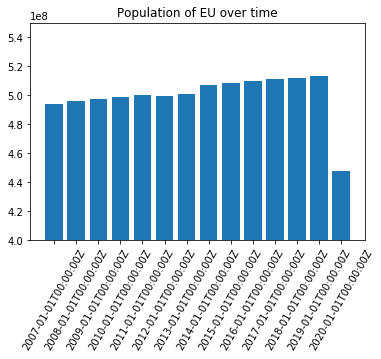

In [3]:
import matplotlib.pyplot as plt
population = df[['Population_P1082', 'Population_point_in_time_P1082_P585']]
population = population[population['Population_point_in_time_P1082_P585'] != 'NA']
population.drop_duplicates(inplace=True)
population.sort_values(by=['Population_point_in_time_P1082_P585'], inplace=True)
plt.xticks(rotation=60)
plt.ylim(400000000, 550000000)
plt.title('Population of EU over time')
plt.bar(population['Population_point_in_time_P1082_P585'], [int(x) for x in population['Population_P1082']])
plt.show()

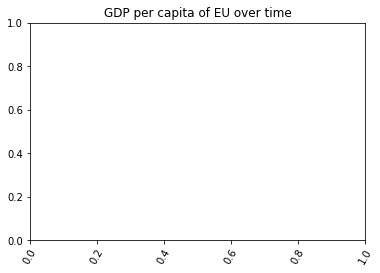

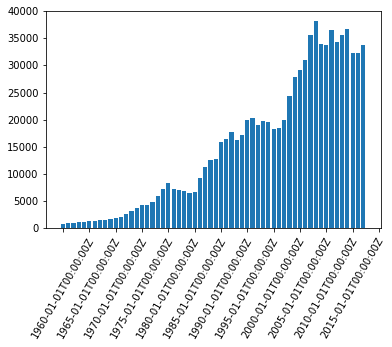

In [4]:
from matplotlib.pyplot import MultipleLocator
gdp = df[['GDP_per_capita_point_in_time_P2132_P585', 'GDP_per_capita_P2132']]
gdp = gdp[gdp['GDP_per_capita_point_in_time_P2132_P585'] != 'NA']
gdp.drop_duplicates(inplace=True)
gdp.sort_values(by=['GDP_per_capita_point_in_time_P2132_P585'], inplace=True)
plt.xticks(rotation=60)
tick_spacing = 5
plt.title('GDP per capita of EU over time')
_, ax = plt.subplots(1, 1)
plt.bar(gdp['GDP_per_capita_point_in_time_P2132_P585'], [float(x) for x in gdp['GDP_per_capita_P2132']])
ax.xaxis.set_major_locator(MultipleLocator(tick_spacing))
plt.xticks(rotation=60)
plt.show()

C:\Users\gaoti\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\gaoti\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


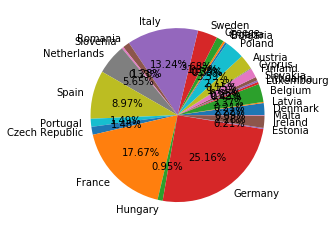

In [9]:
r.extend('P2131', False, 'GDP')
df_gdp = r.query()
df_gdp = df_gdp[['GDP_P2131', 'Countries_P150Label']]
df_gdp.drop_duplicates(inplace=True)
df_gdp
df_gdp['GDP_P2131'] = df_gdp['GDP_P2131'].astype(float)
plt.pie(df_gdp['GDP_P2131'], labels=df_gdp['Countries_P150Label'], autopct='%1.2f%%')
plt.show()

City sizes


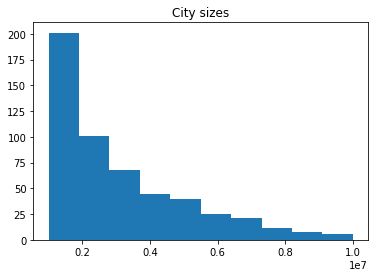

In [5]:
print("City sizes")
r2 = createRelation("Q1549591")
r2.extend("P31", True, "Cities")
r2.changeFocus("Cities_P31")
r2.extend("P1082", False, "Populations")
df2 = r2.query()
df2 = df2[df2['Populations_P1082'] != 'NA']
plt.title('City sizes')
plt.xticks(rotation=360)
plt.hist([float(x) for x in df2['Populations_P1082']], range=(1000000, 10000000))
plt.show()

In [6]:
r3 = createRelation('Q2526255')
r3.extend('P106', True, 'Directors', search='!NA', label=True)
r3.changeFocus('Directors_P106')
r3.extend('P57', True, 'Films', search='!NA', label=True)
r3.changeFocus('Films_P57')
r3.extend('P577', False, 'Time', search=('2010', '2020'))
df3 = r3.query()
df3

,Entity ID,Directors_P106,Directors_P106Label,Films_P57,Films_P57Label,Time_P577
0,http://www.wikidata.org/entity/Q2526255,http://www.wikidata.org/entity/Q26372,Takeshi Kitano,http://www.wikidata.org/entity/Q29825890,Outrage: Final Chapter,2017-01-01T00:00:00Z
1,http://www.wikidata.org/entity/Q2526255,http://www.wikidata.org/entity/Q49847,Ray William Johnson,http://www.wikidata.org/entity/Q63872100,Riley Rewind,2013-12-12T00:00:00Z
2,http://www.wikidata.org/entity/Q2526255,http://www.wikidata.org/entity/Q26372,Takeshi Kitano,http://www.wikidata.org/entity/Q29825890,Outrage: Final Chapter,2017-10-07T00:00:00Z
3,http://www.wikidata.org/entity/Q2526255,http://www.wikidata.org/entity/Q28028,Alfonso Cuarón,http://www.wikidata.org/entity/Q2579784,Gravity,2013-10-03T00:00:00Z
4,http://www.wikidata.org/entity/Q2526255,http://www.wikidata.org/entity/Q28028,Alfonso Cuarón,http://www.wikidata.org/entity/Q2579784,Gravity,2013-10-04T00:00:00Z
...,...,...,...,...,...,...
53782,http://www.wikidata.org/entity/Q2526255,http://www.wikidata.org/entity/Q75823954,Alla Kovgan,http://www.wikidata.org/entity/Q75823148,Cunningham,2020-06-04T00:00:00Z
53783,http://www.wikidata.org/entity/Q2526255,http://www.wikidata.org/entity/Q94440754,Q94440754,http://www.wikidata.org/entity/Q93954815,Atomic Shark,2016-01-01T00:00:00Z
53784,http://www.wikidata.org/entity/Q2526255,http://www.wikidata.org/entity/Q94265854,Rudolf Havlík,http://www.wikidata.org/entity/Q10858003,Q10858003,2014-07-11T00:00:00Z
53785,http://www.wikidata.org/entity/Q2526255,http://www.wikidata.org/entity/Q86826226,Anastasia Mikova,http://www.wikidata.org/entity/Q88482603,Woman,2019-09-01T00:00:00Z


In [7]:
film_gross = pd.read_csv('boxoffice.csv')
film_gross.columns = ['rank', 'Films_P57Label', 'studio', 'gross', 'year']
film_gross['Films_P57Label'] = film_gross['Films_P57Label'].astype(str)
df3['Films_P57Label'] = df3['Films_P57Label'].astype(str)
new_df = film_gross.merge(df3, on='Films_P57Label')
new_df.drop_duplicates(subset=['rank'], inplace=True)
new_df.sort_values(by=['rank'], inplace=True)
new_df.to_csv('boxmerge.csv')

In [70]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)
print("Ultrasound Journal")
r3 = createRelation("Q26842386")
r3.extend("P1476", False, "Titles", rowVerbose=True, colVerbose=True)
df3 = r3.query()
df3

Ultrasound Journal


,Entity ID,Titles_P1476,Titles_rank_P1476_rank,Titles_end_time_P1476_P582,Titles_reason_for_preferred_rank_P1476_P7452,Titles_start_time_P1476_P580,Titles_end_cause_P1476_P1534,Titles_ref_P1476_P854
0,http://www.wikidata.org/entity/Q26842386,Critical Ultrasound Journal,http://wikiba.se/ontology#NormalRank,2018-01-01T00:00:00Z,NA,2009-01-01T00:00:00Z,http://www.wikidata.org/entity/Q84590041,http://blogs.springeropen.com/springeropen/2019/01/25/critical-ultrasound-journal-becomes-ultras...
1,http://www.wikidata.org/entity/Q26842386,The Ultrasound Journal,http://wikiba.se/ontology#PreferredRank,NA,http://www.wikidata.org/entity/Q71536244,2019-01-01T00:00:00Z,NA,http://blogs.springeropen.com/springeropen/2019/01/25/critical-ultrasound-journal-becomes-ultras...


In [71]:
# famous Michigan CS people
r4 = createRelation("Q185667")
r4.extend("P166", True, "Recipients")
r4.changeFocus("Recipients_P166")
r4.extend("P69", False, "School", search="Q230492")
df4 = r4.query()
df4


,Entity ID,Recipients_P166,School_P69
0,http://www.wikidata.org/entity/Q185667,http://www.wikidata.org/entity/Q62870,http://www.wikidata.org/entity/Q230492
1,http://www.wikidata.org/entity/Q185667,http://www.wikidata.org/entity/Q92596,http://www.wikidata.org/entity/Q230492
2,http://www.wikidata.org/entity/Q185667,http://www.wikidata.org/entity/Q9602,http://www.wikidata.org/entity/Q230492
3,http://www.wikidata.org/entity/Q185667,http://www.wikidata.org/entity/Q92758,http://www.wikidata.org/entity/Q230492


In [73]:
r4.changeFocus("School_P69")
r4.extend("P108", True, "Employee")
r4.changeFocus("Employee_P108")
r4.extend("P106", False, "Job", search="Q82594")
r4.extend("P800", False, "Notable_work")
df4 = r4.query()
r4.generate_html('r4.html')
df4

,Entity ID,Recipients_P166,School_P69,Employee_P108,Job_P106,Notable_work_P800
0,http://www.wikidata.org/entity/Q185667,http://www.wikidata.org/entity/Q92758,http://www.wikidata.org/entity/Q230492,http://www.wikidata.org/entity/Q1275356,http://www.wikidata.org/entity/Q82594,NA
1,http://www.wikidata.org/entity/Q185667,http://www.wikidata.org/entity/Q92596,http://www.wikidata.org/entity/Q230492,http://www.wikidata.org/entity/Q1275356,http://www.wikidata.org/entity/Q82594,NA
2,http://www.wikidata.org/entity/Q185667,http://www.wikidata.org/entity/Q9602,http://www.wikidata.org/entity/Q230492,http://www.wikidata.org/entity/Q1275356,http://www.wikidata.org/entity/Q82594,NA
3,http://www.wikidata.org/entity/Q185667,http://www.wikidata.org/entity/Q62870,http://www.wikidata.org/entity/Q230492,http://www.wikidata.org/entity/Q1275356,http://www.wikidata.org/entity/Q82594,NA
4,http://www.wikidata.org/entity/Q185667,http://www.wikidata.org/entity/Q92758,http://www.wikidata.org/entity/Q230492,http://www.wikidata.org/entity/Q1439592,http://www.wikidata.org/entity/Q82594,NA
5,http://www.wikidata.org/entity/Q185667,http://www.wikidata.org/entity/Q92758,http://www.wikidata.org/entity/Q230492,http://www.wikidata.org/entity/Q1504170,http://www.wikidata.org/entity/Q82594,NA
6,http://www.wikidata.org/entity/Q185667,http://www.wikidata.org/entity/Q92596,http://www.wikidata.org/entity/Q230492,http://www.wikidata.org/entity/Q1439592,http://www.wikidata.org/entity/Q82594,NA
7,http://www.wikidata.org/entity/Q185667,http://www.wikidata.org/entity/Q92596,http://www.wikidata.org/entity/Q230492,http://www.wikidata.org/entity/Q1504170,http://www.wikidata.org/entity/Q82594,NA
8,http://www.wikidata.org/entity/Q185667,http://www.wikidata.org/entity/Q62870,http://www.wikidata.org/entity/Q230492,http://www.wikidata.org/entity/Q1439592,http://www.wikidata.org/entity/Q82594,NA
9,http://www.wikidata.org/entity/Q185667,http://www.wikidata.org/entity/Q62870,http://www.wikidata.org/entity/Q230492,http://www.wikidata.org/entity/Q1504170,http://www.wikidata.org/entity/Q82594,NA


In [74]:
df4_ex = r4.query(require=["Notable_work_P800"])
r4.generate_html('r4_ex.html')
df4_ex

,Entity ID,Recipients_P166,School_P69,Employee_P108,Job_P106,Notable_work_P800
68,http://www.wikidata.org/entity/Q185667,http://www.wikidata.org/entity/Q62870,http://www.wikidata.org/entity/Q230492,http://www.wikidata.org/entity/Q6846221,http://www.wikidata.org/entity/Q82594,http://www.wikidata.org/entity/Q29120
71,http://www.wikidata.org/entity/Q185667,http://www.wikidata.org/entity/Q92758,http://www.wikidata.org/entity/Q230492,http://www.wikidata.org/entity/Q6846221,http://www.wikidata.org/entity/Q82594,http://www.wikidata.org/entity/Q29120
72,http://www.wikidata.org/entity/Q185667,http://www.wikidata.org/entity/Q9602,http://www.wikidata.org/entity/Q230492,http://www.wikidata.org/entity/Q6846221,http://www.wikidata.org/entity/Q82594,http://www.wikidata.org/entity/Q29120
77,http://www.wikidata.org/entity/Q185667,http://www.wikidata.org/entity/Q92596,http://www.wikidata.org/entity/Q230492,http://www.wikidata.org/entity/Q6846221,http://www.wikidata.org/entity/Q82594,http://www.wikidata.org/entity/Q29120
93,http://www.wikidata.org/entity/Q185667,http://www.wikidata.org/entity/Q92596,http://www.wikidata.org/entity/Q230492,http://www.wikidata.org/entity/Q15456345,http://www.wikidata.org/entity/Q82594,http://www.wikidata.org/entity/Q382944
95,http://www.wikidata.org/entity/Q185667,http://www.wikidata.org/entity/Q9602,http://www.wikidata.org/entity/Q230492,http://www.wikidata.org/entity/Q15456345,http://www.wikidata.org/entity/Q82594,http://www.wikidata.org/entity/Q382944
96,http://www.wikidata.org/entity/Q185667,http://www.wikidata.org/entity/Q62870,http://www.wikidata.org/entity/Q230492,http://www.wikidata.org/entity/Q15456345,http://www.wikidata.org/entity/Q82594,http://www.wikidata.org/entity/Q382944
98,http://www.wikidata.org/entity/Q185667,http://www.wikidata.org/entity/Q92758,http://www.wikidata.org/entity/Q230492,http://www.wikidata.org/entity/Q15456345,http://www.wikidata.org/entity/Q82594,http://www.wikidata.org/entity/Q382944
107,http://www.wikidata.org/entity/Q185667,http://www.wikidata.org/entity/Q92758,http://www.wikidata.org/entity/Q230492,http://www.wikidata.org/entity/Q92871,http://www.wikidata.org/entity/Q82594,http://www.wikidata.org/entity/Q169478
111,http://www.wikidata.org/entity/Q185667,http://www.wikidata.org/entity/Q92596,http://www.wikidata.org/entity/Q230492,http://www.wikidata.org/entity/Q92871,http://www.wikidata.org/entity/Q82594,http://www.wikidata.org/entity/Q169478


In [75]:
r5 = createRelation("Q76")
r5.extend("P40", False, "Children")
r5.extend("P3373", False, "Siblings")
df5 = r5.query()
df5

,Entity ID,Children_P40,Siblings_P3373
0,http://www.wikidata.org/entity/Q76,http://www.wikidata.org/entity/Q15070044,http://www.wikidata.org/entity/Q773197
1,http://www.wikidata.org/entity/Q76,http://www.wikidata.org/entity/Q15070048,http://www.wikidata.org/entity/Q773197
2,http://www.wikidata.org/entity/Q76,http://www.wikidata.org/entity/Q15070044,http://www.wikidata.org/entity/Q4382677
3,http://www.wikidata.org/entity/Q76,http://www.wikidata.org/entity/Q15070048,http://www.wikidata.org/entity/Q4382677
4,http://www.wikidata.org/entity/Q76,http://www.wikidata.org/entity/Q15070044,http://www.wikidata.org/entity/Q15982167
5,http://www.wikidata.org/entity/Q76,http://www.wikidata.org/entity/Q15070044,http://www.wikidata.org/entity/Q15982189
6,http://www.wikidata.org/entity/Q76,http://www.wikidata.org/entity/Q15070048,http://www.wikidata.org/entity/Q15982167
7,http://www.wikidata.org/entity/Q76,http://www.wikidata.org/entity/Q15070044,http://www.wikidata.org/entity/Q15982309
8,http://www.wikidata.org/entity/Q76,http://www.wikidata.org/entity/Q15070048,http://www.wikidata.org/entity/Q15982189
9,http://www.wikidata.org/entity/Q76,http://www.wikidata.org/entity/Q15070044,http://www.wikidata.org/entity/Q15982322


In [76]:
r6 = createRelation("Q11696")
r6.extend("P39", True, "Presidents")
r6.changeFocus("Presidents_P39")
r6.extend("P19", False, "place_president")
r6.extend("P26", False, "Spouse")
r6.changeFocus("Spouse_P26")
r6.extend("P734", False, "family_name")
r6.extend("P19", False, "place_spouse")
r6.changeFocus("place_spouse_P19")
r6.extend("P6", False, "head", rowVerbose=True, colVerbose=True)
df6 = r6.query()
r6.generate_html("r6.html")
df6

,Entity ID,Presidents_P39,place_president_P19,Spouse_P26,family_name_P734,place_spouse_P19,head_P6,head_rank_P6_rank,head_start_time_P6_P580,head_end_time_P6_P582,head_series_ordinal_P6_P1545,head_political_party_P6_P102,head_end_cause_P6_P1534,head_ref_P6_P577,head_ref_P6_P854,head_ref_P6_P1476,head_ref_P6_P1683,head_ref_P6_P123,head_ref_P6_P813
0,http://www.wikidata.org/entity/Q11696,http://www.wikidata.org/entity/Q35678,http://www.wikidata.org/entity/Q2668659,http://www.wikidata.org/entity/Q234263,http://www.wikidata.org/entity/Q2712864,http://www.wikidata.org/entity/Q990940,http://www.wikidata.org/entity/Q16196403,http://wikiba.se/ontology#NormalRank,2003-01-01T00:00:00Z,2007-01-01T00:00:00Z,NA,NA,NA,NA,https://miamioh.edu/news/top-stories/2016/04/distinguished-service-awards-conley-hatton%20.html,NA,NA,NA,2020-05-10T00:00:00Z
1,http://www.wikidata.org/entity/Q11696,http://www.wikidata.org/entity/Q8007,http://www.wikidata.org/entity/Q988554,http://www.wikidata.org/entity/Q83396,http://www.wikidata.org/entity/Q7366409,http://www.wikidata.org/entity/Q11299,http://www.wikidata.org/entity/Q5518265,http://wikiba.se/ontology#NormalRank,NA,NA,NA,NA,NA,NA,http://manhattanbp.nyc.gov/html/home/home.shtml,NA,NA,NA,2018-11-14T00:00:00Z
2,http://www.wikidata.org/entity/Q11696,http://www.wikidata.org/entity/Q9960,http://www.wikidata.org/entity/Q986310,http://www.wikidata.org/entity/Q193426,http://www.wikidata.org/entity/Q21484687,http://www.wikidata.org/entity/Q11299,http://www.wikidata.org/entity/Q5518265,http://wikiba.se/ontology#NormalRank,NA,NA,NA,NA,NA,NA,http://manhattanbp.nyc.gov/html/home/home.shtml,NA,NA,NA,2018-11-14T00:00:00Z
3,http://www.wikidata.org/entity/Q11696,http://www.wikidata.org/entity/Q23505,http://www.wikidata.org/entity/Q739428,http://www.wikidata.org/entity/Q190628,http://www.wikidata.org/entity/Q1484464,http://www.wikidata.org/entity/Q11299,http://www.wikidata.org/entity/Q5518265,http://wikiba.se/ontology#NormalRank,NA,NA,NA,NA,NA,NA,http://manhattanbp.nyc.gov/html/home/home.shtml,NA,NA,NA,2018-11-14T00:00:00Z
4,http://www.wikidata.org/entity/Q11696,http://www.wikidata.org/entity/Q23505,http://www.wikidata.org/entity/Q739428,http://www.wikidata.org/entity/Q190628,http://www.wikidata.org/entity/Q14921982,http://www.wikidata.org/entity/Q11299,http://www.wikidata.org/entity/Q5518265,http://wikiba.se/ontology#NormalRank,NA,NA,NA,NA,NA,NA,http://manhattanbp.nyc.gov/html/home/home.shtml,NA,NA,NA,2018-11-14T00:00:00Z
5,http://www.wikidata.org/entity/Q11696,http://www.wikidata.org/entity/Q9960,http://www.wikidata.org/entity/Q986310,http://www.wikidata.org/entity/Q193426,http://www.wikidata.org/entity/Q16881921,http://www.wikidata.org/entity/Q11299,http://www.wikidata.org/entity/Q5518265,http://wikiba.se/ontology#NormalRank,NA,NA,NA,NA,NA,NA,http://manhattanbp.nyc.gov/html/home/home.shtml,NA,NA,NA,2018-11-14T00:00:00Z
6,http://www.wikidata.org/entity/Q11696,http://www.wikidata.org/entity/Q9582,http://www.wikidata.org/entity/Q43199,http://www.wikidata.org/entity/Q213122,http://www.wikidata.org/entity/Q11247279,http://www.wikidata.org/entity/Q1297,http://www.wikidata.org/entity/Q432617,http://wikiba.se/ontology#NormalRank,1854-01-01T00:00:00Z,1855-01-01T00:00:00Z,16,http://www.wikidata.org/entity/Q29552,NA,NA,NA,NA,NA,NA,NA
7,http://www.wikidata.org/entity/Q11696,http://www.wikidata.org/entity/Q9582,http://www.wikidata.org/entity/Q43199,http://www.wikidata.org/entity/Q213122,http://www.wikidata.org/entity/Q11247279,http://www.wikidata.org/entity/Q1297,http://www.wikidata.org/entity/Q3246869,http://wikiba.se/ontology#NormalRank,1848-01-01T00:00:00Z,1850-01-01T00:00:00Z,12,http://www.wikidata.org/entity/Q327591,NA,NA,NA,NA,NA,NA,NA
8,http://www.wikidata.org/entity/Q11696,http://www.wikidata.org/entity/Q76,http://www.wikidata.org/entity/Q6366688,http://www.wikidata.org/entity/Q13133,http://www.wikidata.org/entity/Q5280414,http://www.wikidata.org/entity/Q1297,http://www.wikidata.org/entity/Q491860,http://wikiba.se/ontology#No

In [78]:
r7 = createRelation("Q30")
r7.extend("P1082", False, "pop", rowVerbose=True, colVerbose=True, search=(200000000, 250000000))
df7 = r7.query()
df7

,Entity ID,pop_P1082,pop_rank_P1082_rank,pop_point_in_time_P1082_P585,pop_male_population_P1082_P1540,pop_determination_method_P1082_P459,pop_female_population_P1082_P1539,pop_ref_P1082_P248,pop_ref_P1082_P854,pop_ref_P1082_P1476
0,http://www.wikidata.org/entity/Q30,226545805,http://wikiba.se/ontology#NormalRank,1980-04-01T00:00:00Z,NA,NA,NA,http://www.wikidata.org/entity/Q2121710,NA,NA
1,http://www.wikidata.org/entity/Q30,203302031,http://wikiba.se/ontology#NormalRank,1970-04-01T00:00:00Z,NA,NA,NA,http://www.wikidata.org/entity/Q1730452,NA,NA
2,http://www.wikidata.org/entity/Q30,248709873,http://wikiba.se/ontology#NormalRank,1990-04-01T00:00:00Z,NA,http://www.wikidata.org/entity/Q791801,NA,http://www.wikidata.org/entity/Q862577,NA,NA
